<font color = "#CC3D3D"><p>
# (DW Practice #2) RFM Analysis

RFM 분석은 Recency(최근성), Frequency(구매빈도), Monetary(구매금액) 이 세가지 기준을 바탕으로 고객을 분류하는 방법론 (*아래 그림은 KTH 사례*)
 - Recency(R): 고객이 얼마나 최근에 구입했는가? 
 - Frequency(F): 고객이 얼마나 빈번하게 구매했는가? 
 - Monetary(M): 고객이 구입한 총 금액은 얼마인가? 
<img align='left' src='http://drive.google.com/uc?export=view&id=1squaxOpxIS1bRJdM3QbzPXZ2dUS9DbYi' style='width: 80%; height: auto;'>

In [1]:
import pandas as pd
from pandas import Series, DataFrame
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
%matplotlib inline

#pd.set_option('max_columns', 15, 'max_rows', 20)
sns.set_style('whitegrid') # 배경을 흰색, 그리드를 그림.

### Data Collection

#### Read Data

In [2]:
cs = pd.read_csv('L사_고객정보.csv')
cs.head() # 개인정보문제, 나이는 세대

,clnt_id,clnt_gender,clnt_age
0,1,unknown,unknown
1,2,F,30
2,3,unknown,unknown
3,4,unknown,unknown
4,5,unknown,unknown


In [3]:
gd = pd.read_csv('L사_상품정보.csv')
gd.head() # 상품이 대,중,소로 분류 ex)식품-라면-신라면

,pd_c,clac_nm1,clac_nm2,clac_nm3
0,1,Automotive Products,Automotive Replacement Repair / Maintanance Kits,Automobile Oil / Additives
1,2,Automotive Products,Automotive Replacement Repair / Maintanance Kits,Car Lights
2,3,Automotive Products,Automotive Replacement Repair / Maintanance Kits,Car Paint
3,4,Automotive Products,Automotive Replacement Repair / Maintanance Kits,Filters
4,5,Automotive Products,Automotive Replacement Repair / Maintanance Kits,Wiper Blades


In [4]:
tr = pd.read_csv('L사_거래정보.csv')
tr.head()

,clnt_id,trans_id,trans_seq,biz_unit,pd_c,de_dt,de_tm,buy_am,buy_ct
0,21922,104999,1,A03,unknown,20190920,12:41,5990,1
1,21279,104907,4,A03,unknown,20190920,10:27,10900,1
2,39423,105124,11,A03,unknown,20190920,17:26,12900,1
3,18362,104010,1,A03,unknown,20190920,09:57,9900,1
4,39423,105124,13,A03,0565,20190920,17:26,2990,1


#### Merge Data

In [5]:
gd.pd_c = gd.pd_c.astype(str) # 상품과 거래 데이터의 pd_c 컬럼의 데이터 유형이 서로 달라 맞춰줌 
df = pd.merge(tr, cs).merge(gd, on='pd_c')
df.de_dt = df.de_dt.astype(str).astype('datetime64') # 날짜정보를 담고 있는 de_dt 컬럼의 데이터 유형이 정수이기 때문
df.head() # 숫자로 되어 있기 때문에 바로 바꿀수 없음.

,clnt_id,trans_id,trans_seq,biz_unit,pd_c,de_dt,de_tm,buy_am,buy_ct,clnt_gender,clnt_age,clac_nm1,clac_nm2,clac_nm3
0,21922,102455,3,A03,1584,2019-09-18,21:07,2990,1,F,50,Vegetables,Leaf Vegetables,Onions
1,21279,104907,8,A03,1584,2019-09-20,10:27,1000,1,F,40,Vegetables,Leaf Vegetables,Onions
2,21279,105829,14,A03,1584,2019-09-21,13:48,1000,1,F,40,Vegetables,Leaf Vegetables,Onions
3,18362,92227,3,A03,1584,2019-09-06,12:33,2490,1,F,40,Vegetables,Leaf Vegetables,Onions
4,48969,62496,13,A03,1584,2019-08-01,10:59,2590,1,F,40,Vegetables,Leaf Vegetables,Onions


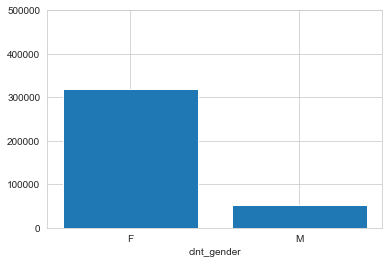

In [6]:
# L사의 남녀별 총 구매수량(buy_ct의 합)을 다음과 같은 모양의 Bar Chart로 도식하시오.
df0 =  df.groupby('clnt_gender')['buy_ct'].sum().reset_index()
x = df0.clnt_gender
y = df0.buy_ct
plt.bar(x, y)
plt.xlabel('clnt_gender')
plt.ylim(0, 500000)
plt.show()

### RFM Calculation

#### Recency value

In [7]:
# 최종 구매일 다음날을 기준으로 계산 
now = df.de_dt.max() + pd.DateOffset(days=1) # datetime64, timedelta데이터 형식이 다름.

# method chaining (multi-line)
recency = (df.groupby('clnt_id')['de_dt']
           .agg(lambda x,y: (y - x).min().days, now).reset_index()
           .rename(columns={'de_dt':'recency'})
          ) # 괄호로 묶어주면 . 찍을때마다 다음라인으로 넘겨도 오류가 안뜸.
recency #클수록 나쁜것

,clnt_id,recency
0,2,32
1,9,17
2,20,1
3,23,3
4,24,28
...,...,...
10093,72361,91
10094,72373,15
10095,72400,37
10096,72410,32


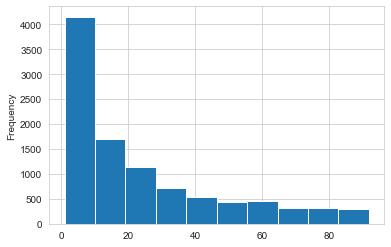

In [8]:
recency.recency.plot.hist()
plt.show()

#### Frequency value

In [9]:
frequency =  df.groupby('clnt_id')['trans_id'].agg([('frequency', Series.nunique)]).reset_index()
frequency

,clnt_id,frequency
0,2,2
1,9,7
2,20,4
3,23,6
4,24,2
...,...,...
10093,72361,1
10094,72373,5
10095,72400,3
10096,72410,7


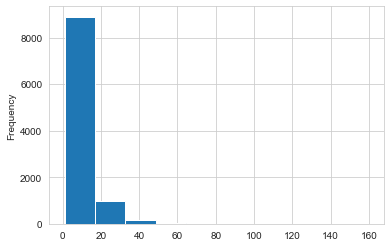

In [10]:
frequency.frequency.plot.hist()
plt.show() # 객체가 나오지 않음.

#### Monetary value

In [11]:
monetary = df.groupby('clnt_id')['buy_am'].agg([('monetary', np.sum)]).reset_index()
monetary

,clnt_id,monetary
0,2,58570
1,9,49680
2,20,51430
3,23,50540
4,24,19840
...,...,...
10093,72361,274930
10094,72373,544710
10095,72400,256900
10096,72410,128760


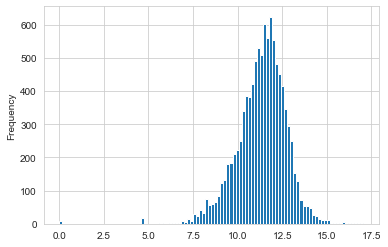

In [12]:
monetary.monetary.apply(lambda x : np.log1p(x)).plot.hist(bins=100) # 종모양 분포로 바꿈.
plt.show() # scale free data

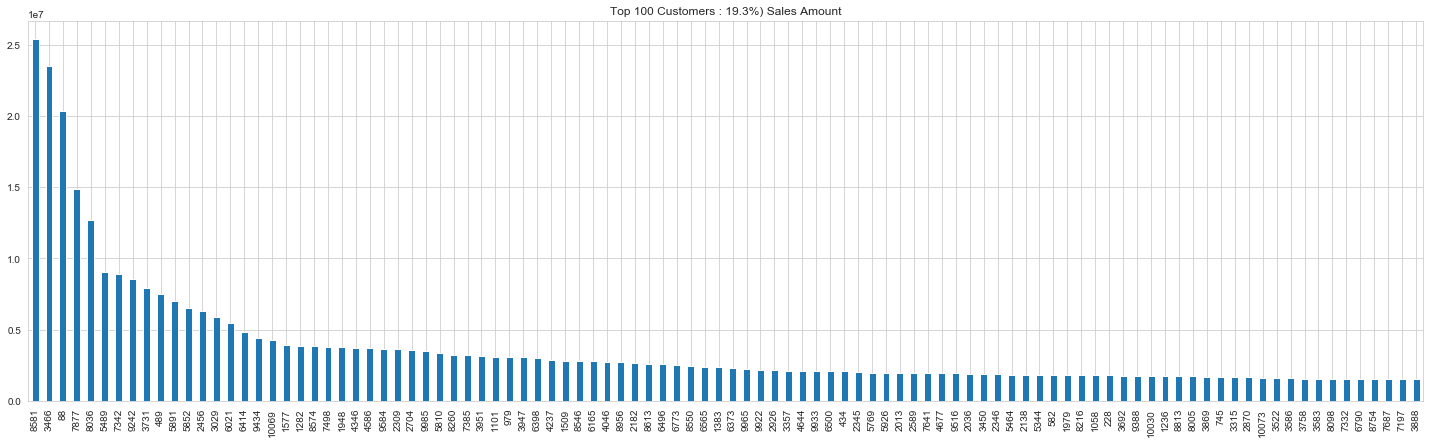

In [13]:
plt.figure(figsize=(25, 7))
top_n = 100 # 상위 1%가 전체의 20%
 
percent_sales = (monetary.monetary.sort_values(ascending=False) \
                 .iloc[:top_n].sum() / monetary.monetary.sum()).round(3)

monetary.monetary.sort_values(ascending=False) \
                .iloc[:top_n].plot.bar(title = f'Top {top_n} Customers : {percent_sales:.1%}) Sales Amount')

plt.show()                                                                     

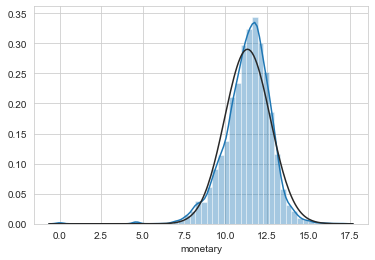

In [14]:
from scipy.stats import norm
sns.distplot(monetary.monetary.apply(lambda x : np.log1p(x)), fit=norm) # fit 검정색 -> 정규분포로 바꿈

#### RFM score

In [15]:
# 위에서 만든 3개의 data_frame를 merge
rfm = recency.merge(frequency).merge(monetary) # dataframe merge
rfm

,clnt_id,recency,frequency,monetary
0,2,32,2,58570
1,9,17,7,49680
2,20,1,4,51430
3,23,3,6,50540
4,24,28,2,19840
...,...,...,...,...
10093,72361,91,1,274930
10094,72373,15,5,544710
10095,72400,37,3,256900
10096,72410,32,7,128760


In [16]:
# recency, frequency, monetary 값을 각각 5분위로 분류하여 점수 부여
rfm['R'] = pd.qcut(rfm['recency'], q=5, labels=range(5,0,-1)).astype(int) # q 는 분위수 작을수록좋은것 -> 클수록좋은것
rfm['F'] = pd.qcut(rfm['frequency'], q=5, labels=range(1,6)).astype(int) # 값이 클수록 좋은것
rfm['M'] = pd.qcut(rfm['monetary'], q=5, labels=range(1,6)).astype(int)
rfm

,clnt_id,recency,frequency,monetary,R,F,M
0,2,32,2,58570,2,1,2
1,9,17,7,49680,3,4,2
2,20,1,4,51430,5,3,2
3,23,3,6,50540,5,3,2
4,24,28,2,19840,2,1,1
...,...,...,...,...,...,...,...
10093,72361,91,1,274930,1,1,5
10094,72373,15,5,544710,3,3,5
10095,72400,37,3,256900,2,2,5
10096,72410,32,7,128760,2,4,4


In [17]:
# R,F,M 점수를 조합하여 RFM 그룹 생성
rfm['RFMgroup'] = rfm['R'].map(str) + rfm['F'].map(str) + rfm['M'].map(str)
rfm

,clnt_id,recency,frequency,monetary,R,F,M,RFMgroup
0,2,32,2,58570,2,1,2,212
1,9,17,7,49680,3,4,2,342
2,20,1,4,51430,5,3,2,532
3,23,3,6,50540,5,3,2,532
4,24,28,2,19840,2,1,1,211
...,...,...,...,...,...,...,...,...
10093,72361,91,1,274930,1,1,5,115
10094,72373,15,5,544710,3,3,5,335
10095,72400,37,3,256900,2,2,5,225
10096,72410,32,7,128760,2,4,4,244


In [18]:
rfm['RFMgroup'].nunique() # 125개의 가지수

119

In [19]:
# R,F,M 에 대한 중요도를 고려하여 RFM 점수 부여
weights = [4, 2, 4] # 가중치
rfm['RFMscore'] = weights[0] * rfm['R'] + weights[1] * rfm['F'] + weights[2] * rfm['M']
rfm # 10점 ~ 50점

,clnt_id,recency,frequency,monetary,R,F,M,RFMgroup,RFMscore
0,2,32,2,58570,2,1,2,212,18
1,9,17,7,49680,3,4,2,342,28
2,20,1,4,51430,5,3,2,532,34
3,23,3,6,50540,5,3,2,532,34
4,24,28,2,19840,2,1,1,211,14
...,...,...,...,...,...,...,...,...,...
10093,72361,91,1,274930,1,1,5,115,26
10094,72373,15,5,544710,3,3,5,335,38
10095,72400,37,3,256900,2,2,5,225,32
10096,72410,32,7,128760,2,4,4,244,32


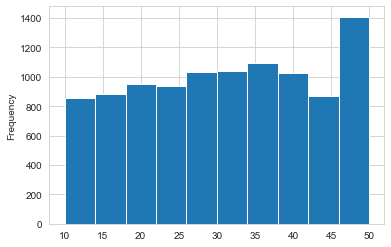

In [20]:
rfm.RFMscore.plot.hist()

### Customer Segmentation

#### Segmentation with Recency and Frequency Grid (*source: clevertap*)

<img align='left' src='https://guillaume-martin.github.io/images/rfm-segments.png'>

In [21]:
# 위 그림에 따라 고객 세분화 
seg_map = { # replace()에서 정규식 사용
    r'[1-2][1-2]': 'hibernating',
    r'[1-2][3-4]': 'at risk',
    r'[1-2]5': 'can\'t loose them',
    r'3[1-2]': 'about to sleep',
    r'33': 'need attention',
    r'[3-4][4-5]': 'loyal customers',
    r'41': 'promising',
    r'51': 'new customers',
    r'[4-5][2-3]': 'potential loyalists',
    r'54': 'champions',
    r'55': 'champion of champions'
}

rfm['segment'] = rfm['R'].map(str) + rfm['F'].map(str)
rfm['segment'] = rfm['segment'].replace(seg_map, regex=True)
rfm.head()

,clnt_id,recency,frequency,monetary,R,F,M,RFMgroup,RFMscore,segment
0,2,32,2,58570,2,1,2,212,18,hibernating
1,9,17,7,49680,3,4,2,342,28,loyal customers
2,20,1,4,51430,5,3,2,532,34,potential loyalists
3,23,3,6,50540,5,3,2,532,34,potential loyalists
4,24,28,2,19840,2,1,1,211,14,hibernating


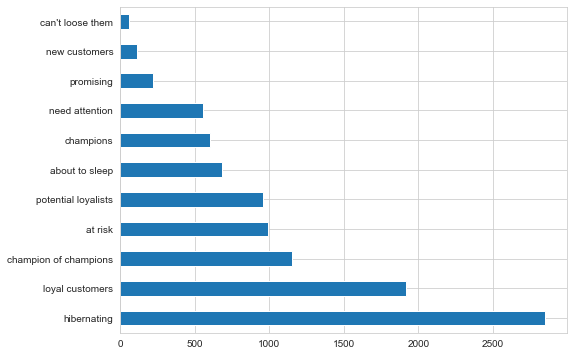

In [22]:
# 세그먼트 별 고객 수
plt.figure(figsize=(8,6))
rfm.segment.value_counts().plot.barh()

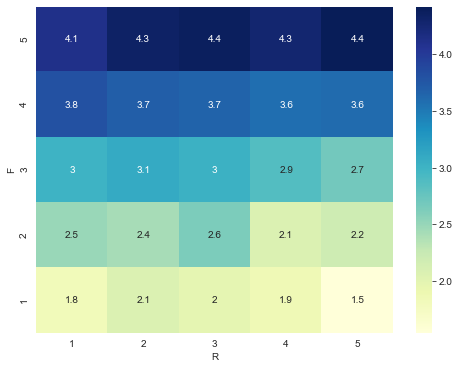

In [23]:
# Recency & Frequency Grid에 Monetary 정보를 추가한 그림
pv = pd.pivot_table(rfm, index='F', columns='R', values='M', aggfunc=np.mean).iloc[::-1,:]
plt.figure(figsize=(8,6))
sns.heatmap(pv, annot=True, cmap="YlGnBu")

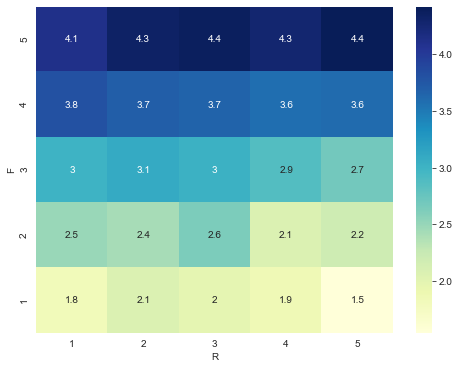

In [24]:
# Recency & Frequency Grid에 Monetary 정보를 추가한 그림
pv = pd.pivot_table(rfm, index='F', columns='R', values='M', aggfunc=np.mean).iloc[::-1,:] # 인덱스를 뒤집어서 5부터 나오게함.
plt.figure(figsize=(8, 6))
sns.heatmap(pv, annot=True, cmap="YlGnBu")
plt.show()

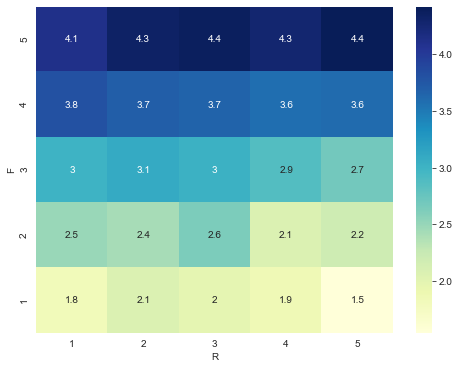

In [25]:
plt.figure(figsize=(8,6))
sns.heatmap(pv, annot=True, cmap='YlGnBu')

#### Further Analysis ...

In [26]:
# 추가분석을 위해 RFM 분석결과를 기존 데이터와 병합
md = pd.merge(df, rfm) ;md

,clnt_id,trans_id,trans_seq,biz_unit,pd_c,de_dt,de_tm,buy_am,buy_ct,clnt_gender,...,clac_nm3,recency,frequency,monetary,R,F,M,RFMgroup,RFMscore,segment
0,21922,102455,3,A03,1584,2019-09-18,21:07,2990,1,F,...,Onions,13,3,12850,3,2,1,321,20,about to sleep
1,21922,102455,5,A03,1566,2019-09-18,21:07,3890,1,F,...,Cucumbers,13,3,12850,3,2,1,321,20,about to sleep
2,21922,39789,1,A03,1581,2019-07-02,02:24,3780,2,F,...,Jumbo Spring Onions,13,3,12850,3,2,1,321,20,about to sleep
3,21922,39789,2,A03,1183,2019-07-02,02:24,1290,1,F,...,Cookies,13,3,12850,3,2,1,321,20,about to sleep
4,21922,51249,2,A03,1573,2019-07-16,23:21,900,1,F,...,Young Pumpkins,13,3,12850,3,2,1,321,20,about to sleep
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
238851,3329,68653,2,A01,1168,2019-08-05,07:46,8800,1,F,...,Aqua Shoes,57,1,17600,1,1,1,111,10,hibernating
238852,23904,109897,1,A01,1634,2019-09-26,12:29,1268000,1,M,...,DSLR,5,1,1268000,4,1,5,415,38,promising
238853,1743,52405,1,A01,1310,2019-07-17,01:48,63200,1,F,...,Women's Golf Bodysuits / Dresses,76,1,63200,1,1,2,112,14,hibernating
238854,8988,100564,1,A01,1312,2019-09-15,07:23,158000,1,F,...,Women's Golf Knitwear / Cardigan,16,1,158000,3,1,4,314,30,about to sleep


In [27]:
# champions 세그먼트의 주요 구매상품 분석
champions = md.query('segment == "champions"').clac_nm2.value_counts().head(5)
champions

Snacks                 2516
Tofu / Bean Sprouts    1575
Instant Noodles        1541
Leaf Vegetables        1238
Biscuits               1137
Name: clac_nm2, dtype: int64

In [28]:
# hibernating 세그먼트의 주요 구매상품 분석
hibernating = md.query('segment == "hibernating"').clac_nm2.value_counts().head(5)
hibernating

Snacks                 1334
Instant Noodles        1136
Tofu / Bean Sprouts     613
Leaf Vegetables         611
Biscuits                594
Name: clac_nm2, dtype: int64

In [29]:
# 위의 두 세그먼트 비교분석
DataFrame({"champions": champions.index, "hibernating": hibernating.index})

,champions,hibernating
0,Snacks,Snacks
1,Tofu / Bean Sprouts,Instant Noodles
2,Instant Noodles,Tofu / Bean Sprouts
3,Leaf Vegetables,Leaf Vegetables
4,Biscuits,Biscuits


In [30]:
# 전체 세그먼트 주요 구매상품 비교분석
DataFrame({seg: md.query('segment == @seg').clac_nm2.value_counts().head(5).index for seg in seg_map.values()})

,hibernating,at risk,can't loose them,about to sleep,need attention,loyal customers,promising,new customers,potential loyalists,champions,champion of champions
0,Snacks,Snacks,Snacks,Snacks,Snacks,Snacks,Snacks,Snacks,Snacks,Snacks,Snacks
1,Instant Noodles,Instant Noodles,Climbing,Instant Noodles,Instant Noodles,Tofu / Bean Sprouts,Instant Noodles,Instant Noodles,Instant Noodles,Tofu / Bean Sprouts,Tofu / Bean Sprouts
2,Tofu / Bean Sprouts,Tofu / Bean Sprouts,Leaf Vegetables,Tofu / Bean Sprouts,Tofu / Bean Sprouts,Instant Noodles,Biscuits,Biscuits,Tofu / Bean Sprouts,Instant Noodles,Leaf Vegetables
3,Leaf Vegetables,Leaf Vegetables,Tofu / Bean Sprouts,Leaf Vegetables,Leaf Vegetables,Leaf Vegetables,Leaf Vegetables,Tofu / Bean Sprouts,Leaf Vegetables,Leaf Vegetables,Fruit Vegetables
4,Biscuits,Fruit Vegetables,Instant Noodles,Biscuits,Fruit Vegetables,Fruit Vegetables,Tofu / Bean Sprouts,Leaf Vegetables,Biscuits,Biscuits,Instant Noodles


### 또 다른 RFM 분석사례 (*FedEx*)
- 대상고객: 전체 4개의 서비스 상품 중 2개의 상품을 구매한 고객
- 대상실적: 최근 6개월간 서비스 이용실적
- 점수부여방식
  - Recency = 최근 3개월 이내 이용 -> 2점, 3개월 이전 이용 -> 1점
  - Frequency = 최근 6개월간총서비스 이용 횟수
  - Monetary = 최근 6개월 간 총 이용금액
- 점수산출방식
  - R점수 * F점수 * M점수
- 관리방식
  - 전체 고객을 총 10개의 군으로 구분하여 관리

<font color = "#CC3D3D"><p>
# End